In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import os
import sys
import logging

In [3]:
# adata_rbpj_imputed = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/stream_objs/rbpj_rna_imputed_v2.h5ad"
adata_rbpj = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects/Rbpj_v1.h5ad"
adata_ets1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects/Ets1_v1.h5ad"
adata_ikzf1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects/Ikzf1_v1.h5ad"
adata_ntc = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects/adata_ntc.h5ad"

stream_obj = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/stream_objs/rbpj_ntc.pkl"
out_dir = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects"

#### Concat the NTCs of all KO experiments to increase cell numbers

In [3]:
import scanpy as sc

adata_rbpj = sc.read(adata_rbpj)
adata_ets1 = sc.read(adata_ets1)
adata_ikzf1 = sc.read(adata_ikzf1)
adata_rbpj_ntc = adata_rbpj[adata_rbpj.obs.condition == "NTC"]
adata_ets1_ntc = adata_ets1[adata_ets1.obs.condition == "NTC"]
adata_ikzf1_ntc = adata_ikzf1[adata_ikzf1.obs.condition == "NTC"]

In [4]:
#concat the NTC adatas
adata_ntc = adata_rbpj_ntc.concatenate(adata_ets1_ntc,adata_ikzf1_ntc)

/tmp/ipykernel_70380/3437704833.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_ntc = adata_rbpj_ntc.concatenate(adata_ets1_ntc,adata_ikzf1_ntc)


In [6]:
adata_ntc.obs['genotype'].value_counts()

genotype
0        14044
NTC      10562
sgNTC     5175
Name: count, dtype: int64

In [7]:
#convert all genotypes to sgNTC
adata_ntc.obs['genotype'] = 'sgNTC'
adata_ntc.obs['genotype'].value_counts()

genotype
sgNTC    29781
Name: count, dtype: int64

In [8]:
colormap = {'Tpex': 'darkblue', 'Tex': 'lightpink'}
categories = adata_ntc.obs['cell_cluster'].cat.categories
display(categories)
display(adata_ntc.obs['cell_cluster'].value_counts())

Index(['Tex', 'Tpex'], dtype='object')

cell_cluster
Tex     16045
Tpex    13736
Name: count, dtype: int64

In [9]:
# First, make sure the colors are in the same order as the categories
colors = [colormap[cat] for cat in categories]
# Set the colors in adata.uns
adata_ntc.uns['cell_cluster_colors'] = colors

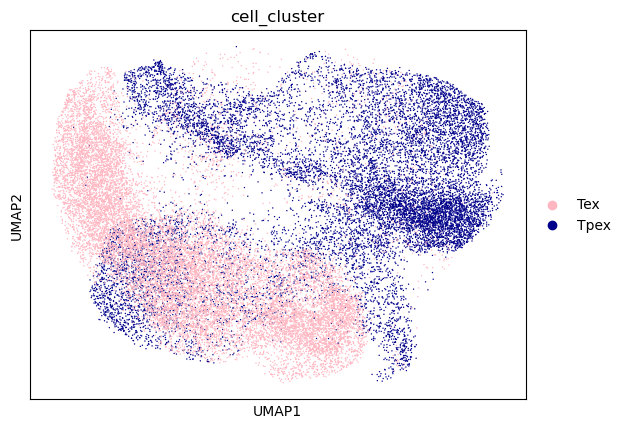

In [10]:
sc.pl.umap(adata_ntc,color=['cell_cluster'])

In [11]:
adata_ntc

AnnData object with n_obs × n_vars = 29781 × 1238
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'genotype', 'RNA_snn_res.0.5', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.1.2', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'celltype5', 'cell_cluster', 'condition', 'celltype', 'celltype2', 'batch'
    var: 'vst.variable', 'vst.mean-0', 'vst.variance-0', 'vst.variance.expected-0', 'vst.variance.standardized-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.mean-2', 'vst.variance-2', 'vst.variance.expected-2', 'vst.variance.standardized-2'
    uns: 'cell_cluster_colors'
    obsm: 'X_pca', 'X_umap'

In [12]:
sc.write(os.path.join(out_dir, 'adata_ntc.h5ad'), adata_ntc)

### Stream 

In [4]:
from os.path import basename
import stream as st
adata = st.read(file_name=adata_ntc, workdir=out_dir)
#adata_imputed = st.read(file_name=adata_rbpj_imputed, workdir=out_dir)
#adata_rbpj_ntc = adata[adata.obs.condition == "NTC"]
# import scanpy as sc
# adata_rbpj = sc.read(adata_rbpj)

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Saving results in: /ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects


In [5]:
adata

AnnData object with n_obs × n_vars = 29781 × 1238
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'genotype', 'RNA_snn_res.0.5', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.1.2', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'celltype5', 'cell_cluster', 'condition', 'celltype', 'celltype2', 'batch'
    var: 'vst.variable', 'vst.mean-0', 'vst.variance-0', 'vst.variance.expected-0', 'vst.variance.standardized-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.mean-2', 'vst.variance-2', 'vst.variance.expected-2', 'vst.variance.standardized-2'
    uns: 'cell_cluster_colors', 'workdir'
    obsm: 'X_pca', 'X_umap'

#### Add obs (condition and cluster label)

In [ ]:
# # the number to label mapping is the same for all TFs

# cell_type_annotation = {    "Tpex":[0,1],
#                             "Tex": [2,3],}

# cell_type_annotation_reverse = {}
# for i in set(adata_ikzf1.obs.celltype2):
#     for k in cell_type_annotation:
#         if int(i) in cell_type_annotation[k]:
#             cell_type_annotation_reverse[i] = k
# adata_ikzf1.obs["cell_cluster"] = [cell_type_annotation_reverse[i] for i in adata_ikzf1.obs.celltype2]

In [ ]:
# condition_annotation = {
#     "KO": ['S2_sgRbpj', 'S3_sgEts1', 'S4_sgEts1', 'S2_sgIkzf1', 'S4_sgIkzf1'],
#     "NTC": ['S4_sgNTC', 'S1_NTC', 'S2_NTC', 'S1_Spike', 'S3_Spike']
# }
# # Invert the dictionary
# sample_to_condition = {}
# for condition, samples in condition_annotation.items():
#     for sample in samples:
#         sample_to_condition[sample] = condition

# # Now map it to your adata object
# adata_ikzf1.obs["condition"] = adata_ikzf1.obs["orig.ident"].map(sample_to_condition)

## Pre-processing for stream

In [7]:
st.cal_qc(adata,assay='rna')

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/stream/core.py:427: RuntimeWarning: divide by zero encountered in true_divide
  adata.obs['pct_mt'] = n_counts_mt/n_counts


In [8]:
st.filter_cells(adata,min_n_features= 100)
st.filter_features(adata,min_n_cells = 5)

filter cells based on min_n_features
after filtering out low-quality cells: 
20470 cells, 1238 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
20470 cells, 1237 genes


In [9]:
###Normalize gene expression based on library size  
st.normalize(adata,method='lib_size')
###Logarithmize gene expression 
st.log_transform(adata)
###Remove mitochondrial genes 
st.remove_mt_genes(adata)

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/stream/core.py:748: RuntimeWarning: invalid value encountered in log2
  adata.X = np.log2(adata.X+1)/np.log2(base)


remove mitochondrial genes:
['mt-Nd1', 'mt-Cytb']


In [10]:
import numpy as np
import scipy.sparse as sp

X = adata.X

In [11]:
if sp.issparse(X):
    data = X.data
    data[np.isnan(data)] = 0
    X.eliminate_zeros()
else:
    np.nan_to_num(X, copy=False)  # in-place: NaN->0, inf->large finite

In [12]:
n_nans = np.isnan(X.data).sum() if sp.issparse(X) else np.isnan(X).sum()
display(n_nans)
display(adata.X.size)

0

25280450

In [13]:
display(adata.X)

array([[12.81024174, 12.06742229,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [11.87652179, 12.65843492, 11.22804966, ...,  7.26521576,
         6.52436811,  6.37355792],
       [11.70270017, 11.02412334,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [10.99991986, 11.55530921,  0.        , ...,  7.05981004,
         5.61870721,  6.23254676],
       [11.70219986, 11.72585061,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [11.69192885, 11.3009288 ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# Run stream dim reduction

247 variable genes are selected


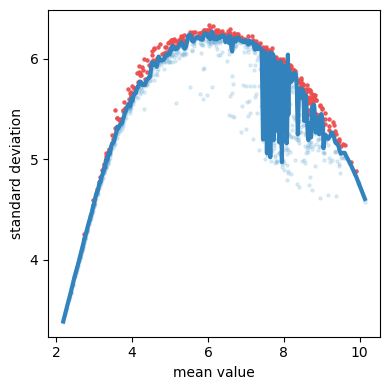

In [14]:
# # Setting var_genes if you need to select top 3k genes from a list of more than 3k genes
#adata_imputed.X = adata_imputed.layers['MAGIC_imputed_data']
st.select_variable_genes(adata,loess_frac=0.01,percentile=80)

In [15]:
# # 'var_genes' vs 'all' : use top % or all genes from .var ; if using all make sure the adata is subsetted to only the highly variable genes
# # n_components = Number of branches present in your biological differentation
st.dimension_reduction(adata,method='se',feature='var_genes',n_components=2,n_neighbors=30,n_jobs=64) # using the same knn as diffusion maps (default is 30)

feature var_genes is being used ...
64 cpus are being used ...


In [16]:
# # Order the cell states for plotting (colors need to be categorical)
adata.obs['cell_cluster'] = pd.Categorical(
    adata.obs['cell_cluster'],
    categories=['Tpex', 'Tex'],
    ordered=True
)
colormap = {'Tpex': 'darkblue', 'Tex': 'lightpink'}
# Create a new column in adata.obs for colors
adata.obs['cell_cluster_colors'] = adata.obs['cell_cluster'].map(colormap)

In [17]:
adata_Tpex = adata[adata.obs['cell_cluster'] == 'Tpex']
adata_Tex = adata[adata.obs['cell_cluster'] == 'Tex']


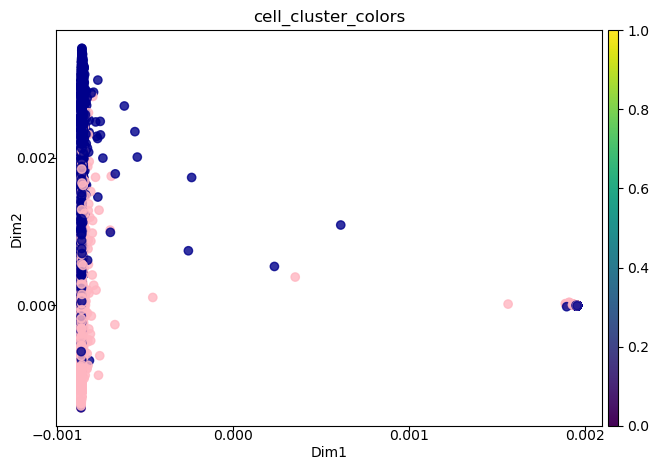

In [18]:
st.plot_dimension_reduction(adata, color=['cell_cluster_colors'], n_components=2)

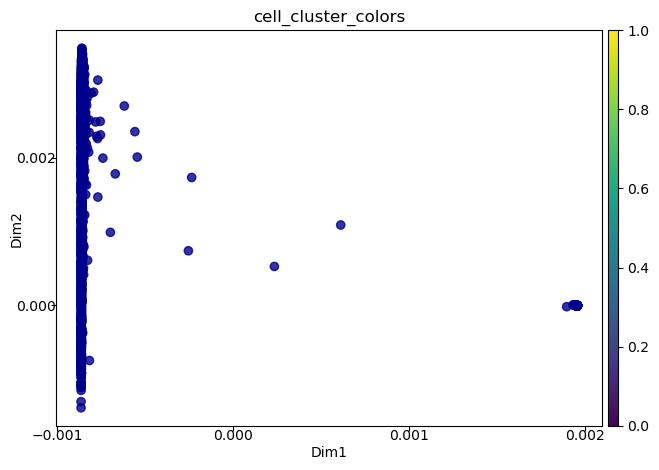

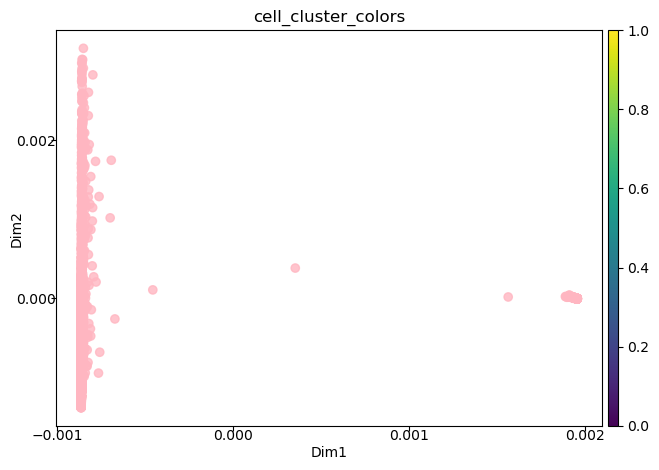

In [20]:
st.plot_dimension_reduction(adata_Tpex, color=['cell_cluster_colors'], n_components=2)
st.plot_dimension_reduction(adata_Tex, color=['cell_cluster_colors'], n_components=2)

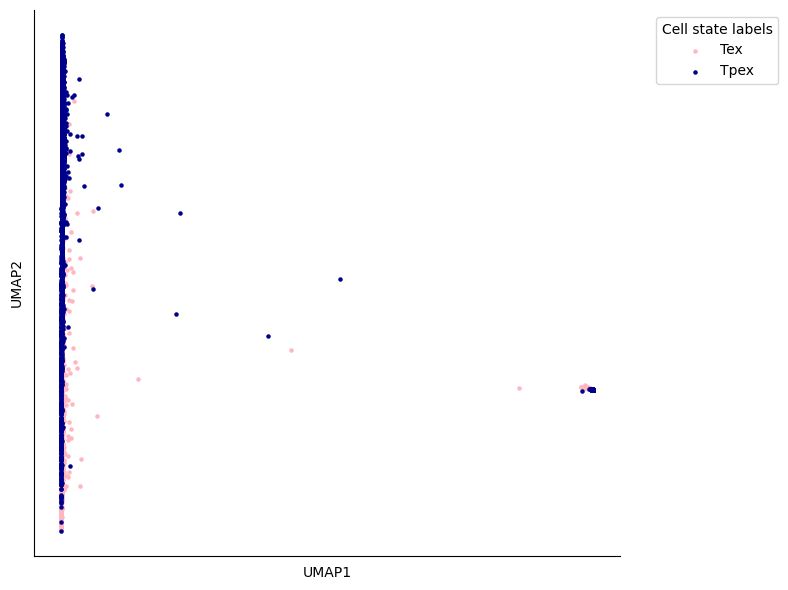

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr'/'X_mlle' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['cell_cluster']

# Get unique labels and their corresponding colors
unique_labels = labels.unique()
color_list = [colormap[label] for label in unique_labels]

# Plotting the UMAP with colors based on labels
plt.figure(figsize=(8, 6))

for label, color in zip (unique_labels, color_list):
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=color, label=label, s=5)  # s=5 sets the marker size to 5 points
# Remove ticks
plt.xticks([])
plt.yticks([])
# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title="Cell state labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/figures/bifurcation_male.pdf', 
#             bbox_inches='tight',  # Ensures the legend isn't cut off
#             dpi=300,             # High resolution
#             format='pdf')        # Specify PDF format
plt.show()

## Infer the traj by fitting elastic graph

In [21]:
import os
os.environ.pop('R_LIBS_USER', None)  # Remove custom library path
os.environ.pop('R_LIBS', None)

'/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/R/library'

In [22]:
from rpy2.robjects import r
r('library(rlang)')

'rlang','tools','stats','graphics',...,'utils','datasets','methods','base'


In [23]:
import os
os.environ["OMP_NUM_THREADS"] = "64"
from tempfile import TemporaryDirectory

# Parameters for STREAM (tune to your dataset)
ka1={'epg_alpha':0.02,'epg_mu':0.07,'epg_lambda':0.02,'epg_trimmingradius':2} # epg_mu needs to be tuned to get a good branch for day-1 to activated and undefined cells
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata,td)
	st.seed_elastic_principal_graph(adata,n_clusters=10)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)
	

Saving results in: /tmp/tmp__f2g1ch
Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 3
Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 20470 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50
	
2.425e-08
	
50
	
49
	
46
	
1
	
0
	
0
	
2.729e-09
	
1.962e-09
	
0.9992
	
0.9994
	
2.024e-08
	
1.275e-09
	
6.376e-08
	
3.188e-06
	
0




/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


70.476 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 3
Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


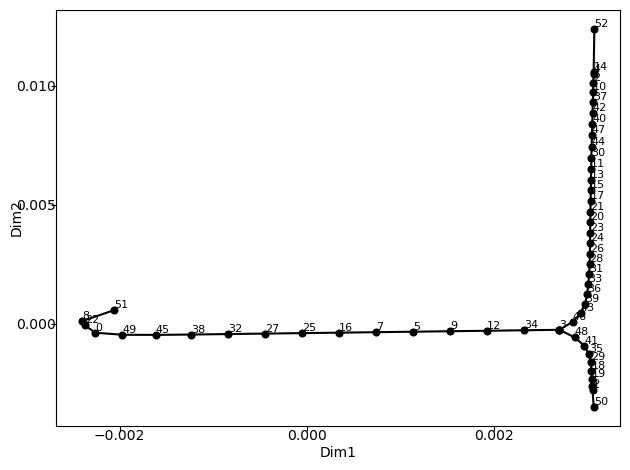

In [24]:
st.plot_branches(adata_rbpj_ntc,show_text=True, n_components=2)

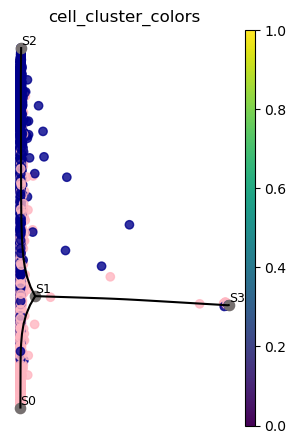

In [24]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True,color=['cell_cluster_colors'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


In [25]:
# subset adata to exclude cells on branch S0,S1
adata.obs['branch_id_alias'].value_counts()

(S0, S1)    10105
(S3, S1)     6274
(S2, S1)     4091
Name: branch_id_alias, dtype: int64

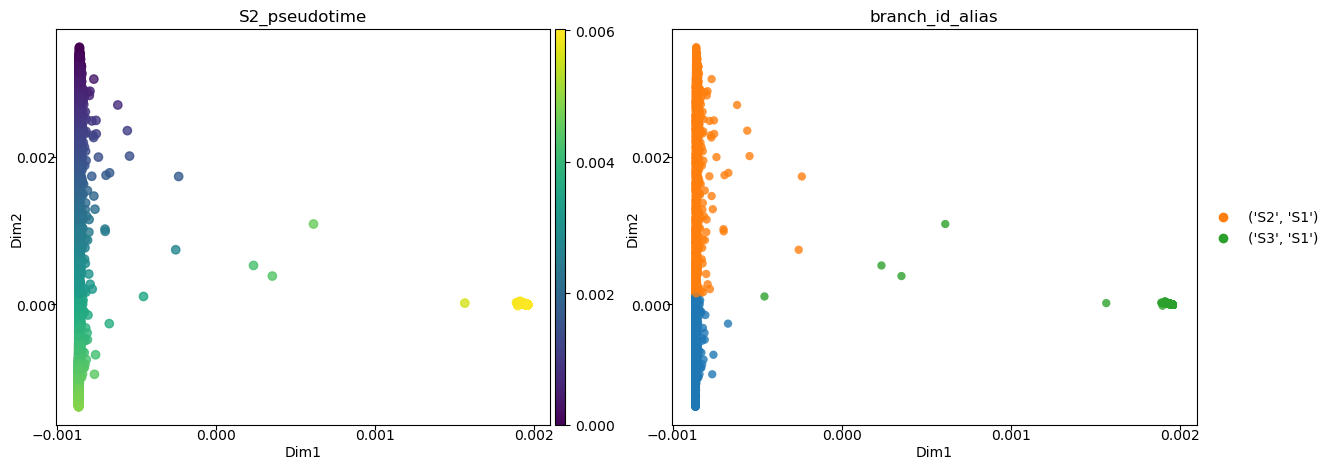

In [28]:
#Replace S3 with your own starting node if on a different dataset
st.plot_dimension_reduction(adata,color=['S2_pseudotime','branch_id_alias'])

In [29]:
# write adata_rbpj_ntc to a file
st.write(adata, file_name='/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/stream_objs/all_ntc.pkl')